# Import of libraries


In [1]:
# pandas
import pandas as pd

# numpy
import numpy as np

# sklearn
import sklearn

# math
import math

#seaborn
import seaborn as sns

# sklearn (pre)processing & pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

#sklearn metrics & curves
from sklearn.metrics import  recall_score, precision_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve


#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

#sklearn Classifier models
from sklearn.linear_model import LogisticRegression     #LogisticRegression
from sklearn.neighbors import KNeighborsClassifier      #Nearest Neighbor
#from sklearn.svm import SVC                             #Support Vector Machine
from sklearn.tree import DecisionTreeClassifier         #Decision Tree
from sklearn.ensemble import RandomForestClassifier     #Random Forest
#from sklearn.naive_bayes import GaussianNB              #Naive Bayes
#from sklearn.ensemble import GradientBoostingClassifier #Gradient Boosting

#mathplot
import matplotlib.pyplot as plt


# Functions for Cost Based Thresholding

In [2]:
def binary_clf_curve(y_true, y_score):
    
    #make Numpy arrays from pd.Series
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()

    if isinstance(y_score, pd.Series):
        y_score = y_score.to_numpy()
    
    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    
    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = np.cumsum(y_true)[threshold_idxs]
    
    fps = 1 + threshold_idxs - tps
    fns = tps[-1] - tps
    thresholds = y_score[threshold_idxs]
    return tps, fps, fns, thresholds

In [3]:
# Function to illustrates the process of Empirical Cost-Based Thresholding
def empirical_costbased_thresholding(y_true, scores, model_name, C_FP, C_FN, p=False):
    """
    Illustrates Empirical Cost-Based Thresholding

    Parameters
    ----------
    scores : ndarray of shape (n_samples,)
        Predicted scores for all samples (e.g. classifier outputs or probabilities).
    model_name : str
        Name of the model, used for labeling or output purposes.
    C_FP : int or float
        Cost associated with a false positive classification.
    C_FN : int or float
        Cost associated with a false negative classification.
    p : bool, optional (default=False)
        If True, the scores are probability-like and range from 0 to 1.
        and will be compared with the theoretical 
    """
    
    
    true_positives, false_positives,  false_negatives, thresholds = binary_clf_curve(y_true, scores)
    
    total_costs = C_FP * false_positives + C_FN * false_negatives  
    
    plt.figure()
    
    plt.plot(thresholds, total_costs, marker='o',color='blue' , linestyle='-')
    plt.plot(thresholds, total_costs,  linestyle='-',color='blue', linewidth=4, label= 'Total Expected Cost')
    
    
    if(p):
        plt.xlabel("Probability Threshold")
    else:
        plt.xlabel("Threshold")
    plt.ylabel("Cost")
    plt.title(f"Cost vs. Threshold - {model_name}")
    
    min_cost_index = np.argmin(total_costs)
    optimal_threshold = thresholds[min_cost_index]
    
    plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.legend()
    plt.show()
    
    TP = true_positives[min_cost_index]
    FP = false_positives[min_cost_index]
    FN = false_negatives[min_cost_index]
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
                    
    
    threshold_with_calibrated_p = C_FP/(C_FN+C_FP)
    print(f"Optimal threshold for {model_name}: {optimal_threshold:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Empirically minimized expected costs: {total_costs[min_cost_index]:.2f}")
    print(f"Empirically minimized expected costs per item: {total_costs[min_cost_index]/len(y_true):.2f}")
    
    if(p):
        print(" ")
        print(f"With calibrated p threshold would be: {threshold_with_calibrated_p:.2f}")
        index = np.searchsorted(-thresholds, -threshold_with_calibrated_p, side='right') - 1
        print(f"Expected cost with this calibrated p threshold: {total_costs[index]:.2f}")    
    
    return optimal_threshold

In [61]:
# Function to calculate the average cost
def myAveragedCosts(y_true, y_pred, C_FP, C_FN):
    score = confusion_matrix(y_true, y_pred)[1,0]*C_FN + confusion_matrix(y_true, y_pred)[0,1]*C_FP 
    return score/len(y_true)

# Prepare Data

## Description of the data

Variables Table

| Variable Name | Role | Type | Demographic | Description | Units | Missing Values |
|---------------|------|------|-------------|-------------|-------|----------------|
| age           | Feature | Integer | Age | | | no |
| job | Feature | Categorical | Occupation | type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') | | no |
| marital | Feature | Categorical | Marital Status | marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) | | no |
| education | Feature | Categorical | Education Level | (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') | | no |
| default | Feature | Binary | | has credit in default? | | no |
| housing | Feature | Binary | | has housing loan? | | no |
| loan | Feature | Binary | | has personal loan? | | no |
| contact | Feature | Categorical | | contact communication type (categorical: 'cellular','telephone') | | yes |
| day_of_week | Feature | Date | | last contact day of the week | | no |
| month | Feature	 | Date | | last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') | | no |
| duration | Feature | Integer | | last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. | | no |
| campaign | Feature | Integer | | number of contacts performed during this campaign and for this client (numeric, includes last contact) | | no |
| pdays | Feature | Integer | | number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) | | yes |
| previous | Feature | Integer | | number of contacts performed before this campaign and for this client | | no |
| poutcome | Feature | Categorical | | outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') | | yes |
| emp.var.rate | Feature | float64 | | Employment variation rate, with a quarterly frequency | | no |
| cons.price.idx | Feature | float64 | | Monthly average consumer price index | | no |
| cons.conf.idx | Feature | float64 | | Monthly average consumer confidence index | | no |
| euribor3m | Feature | float64 | | Daily three month Euribor rate | | no |
| nr.employed | Feature | float64 | | Quarterly average of the total number of employed citizens | | no |
| y	| Target | Binary | | has the client subscribed a term deposit? | | |

## Import of Data

In [4]:
# Inladen met de juiste scheidingstekens
# bank_data_small = pd.read_csv('../../Data/bank-additional/bank-additional.csv', sep=';')
bank_data_full = pd.read_csv('Data/bank-additional/bank-additional-full.csv', sep=';')

In [5]:
average_call_seconds = round(bank_data_full["duration"].mean(), 2)
average_call_minutes = round(average_call_seconds/60, 2)

In [6]:
# Based on the Variables Table (see above) the column 'duration' will not be used for predictive purposes
bank_data_full = bank_data_full.drop("duration", axis='columns')

In [7]:
bank_data_full.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
bank_data_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
bank_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [10]:
bank_data_full.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [11]:
print("Continuous Variables: ")
continous_vars=bank_data_full.describe().columns  #get the names of numerical variables, in this case continuous variables
print(continous_vars)

print("\nCategorical Variables: ")
categorical_vars=bank_data_full.describe(include=[object]).columns
print(categorical_vars)

Continuous Variables: 
Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

Categorical Variables: 
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


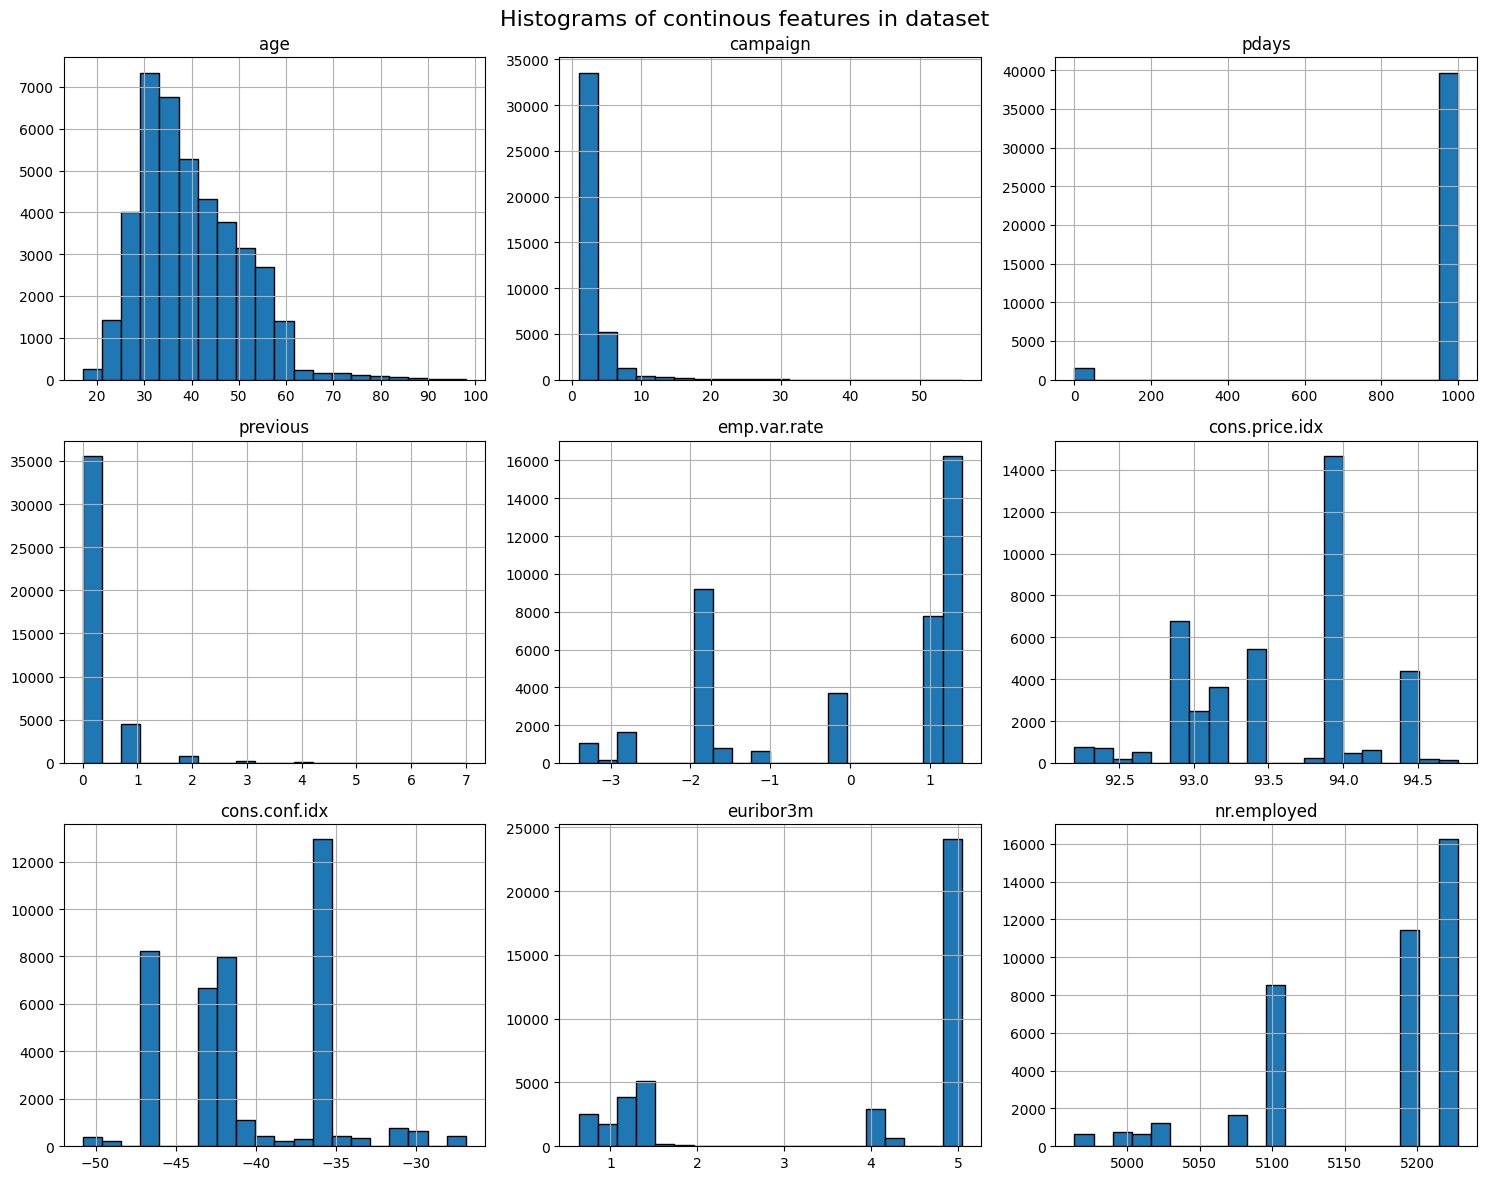

In [12]:
bank_data_full.hist(column=continous_vars, bins=20, figsize=(15, 12), edgecolor="black")
plt.suptitle("Histograms of continous features in dataset", fontsize=16)
plt.tight_layout()
plt.show()

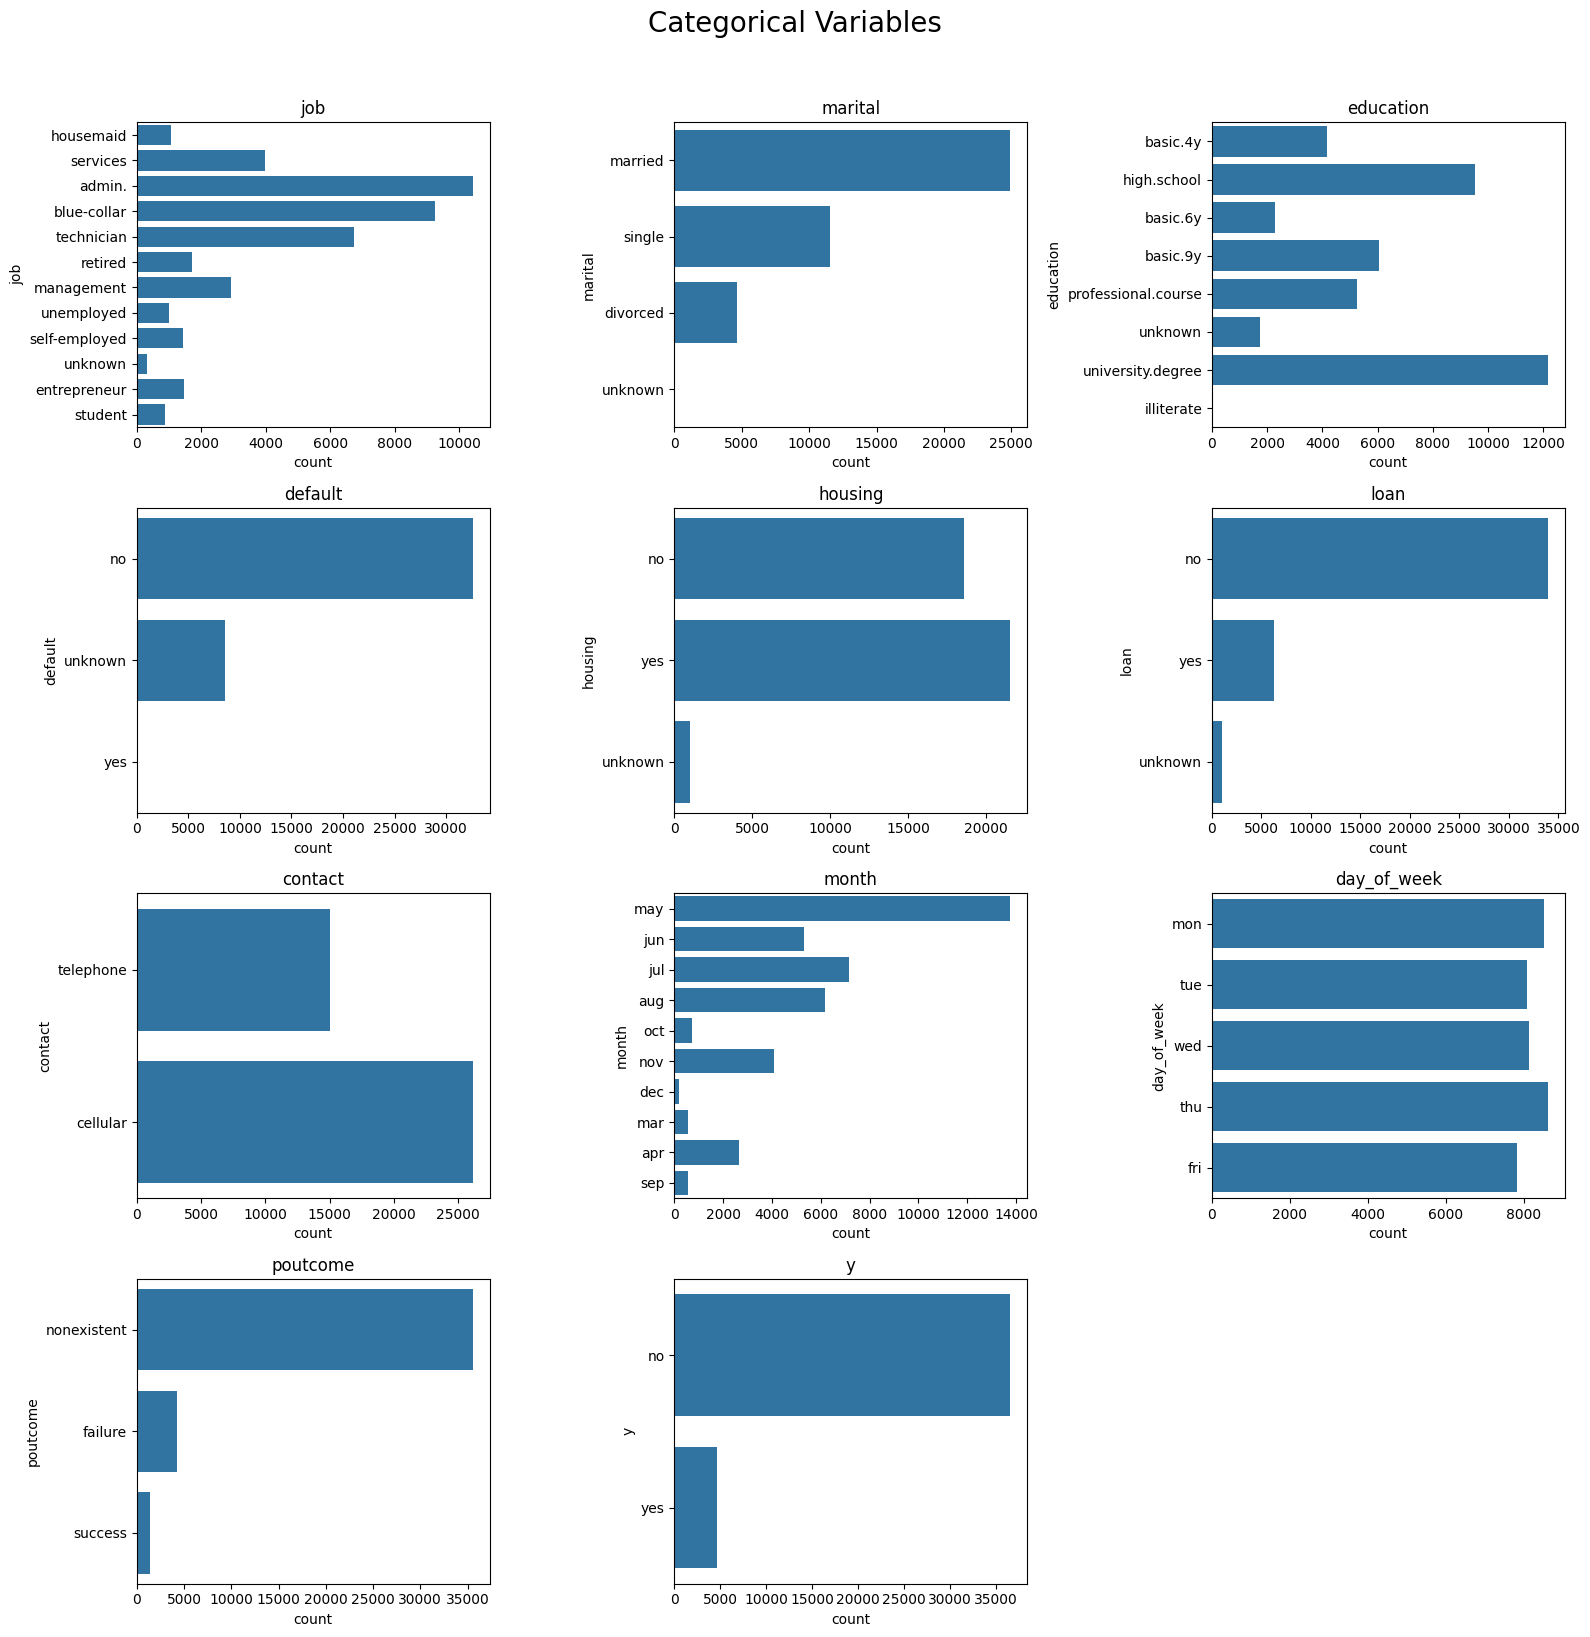

In [13]:
n = len(categorical_vars) # number of categorical variables

cols = 3
rows = math.ceil(n / cols) # automatically determine rows and columns

plt.figure(figsize=(16, rows * 4))

plt.suptitle("Categorical Variables", fontsize=20, y=1.02)

for i, col in enumerate(categorical_vars, start=1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=bank_data_full, y=col)
    plt.title(col)

plt.tight_layout()
plt.show()

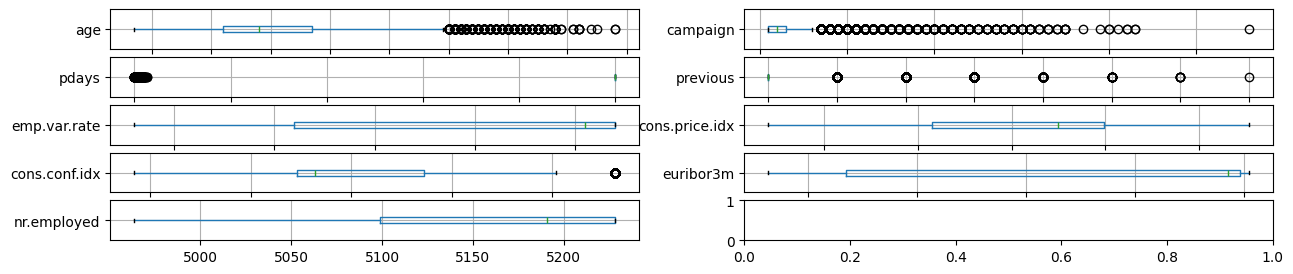

In [14]:
# number of boxes to plot is number of columns in df that are not an object.
columns_in_df = bank_data_full.select_dtypes(exclude='object').shape[1]

#number in columns in plot is 2 and number of rows is number of columns in df/number of columns in plot, rounded upwards
ncols = 2
nrows = math.ceil(columns_in_df/ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 3) )

axsrow=0
axscol=0

for label, values in bank_data_full.items():
    if values.dtype != object:
        if axscol == 2:
            axsrow = axsrow + 1
            axscol = 0
        bank_data_full.boxplot(column=[label], vert=False, ax=axs[axsrow,axscol])
        axscol = axscol + 1

plt.xticks()
plt.show()    


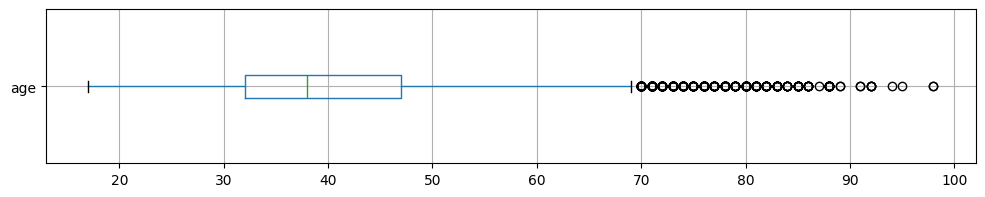

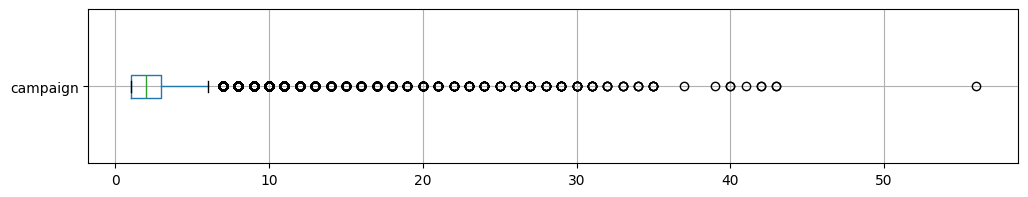

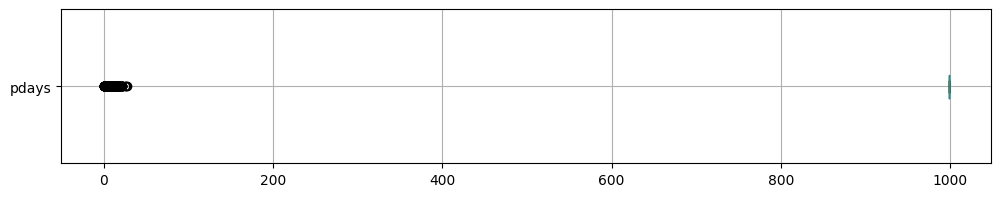

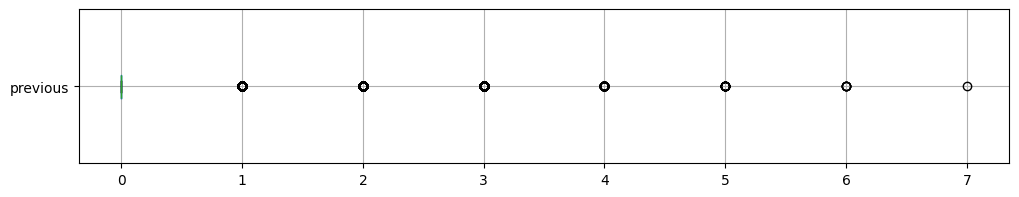

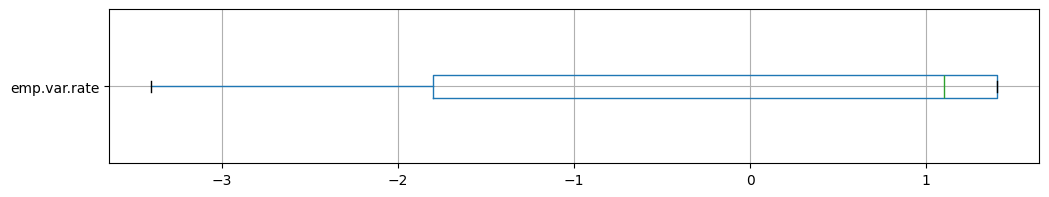

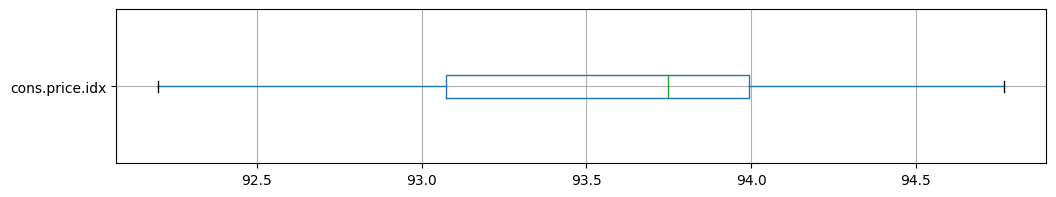

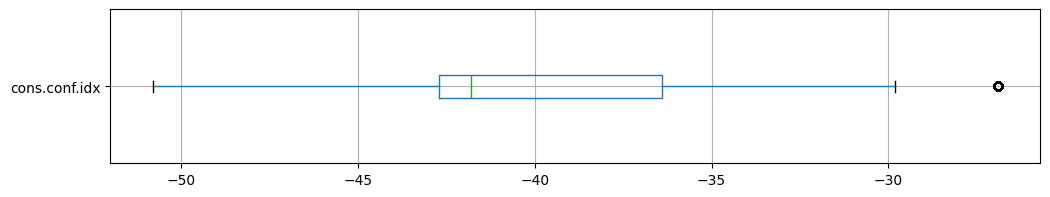

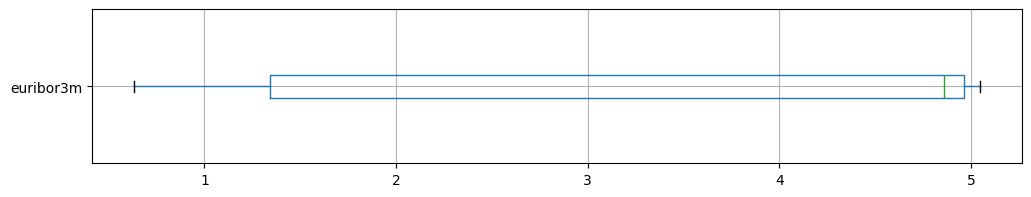

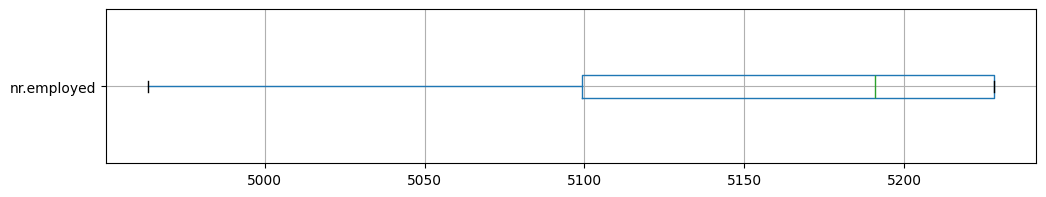

In [15]:
for label, values in bank_data_full.items():
    if values.dtype != object:
        bank_data_full.boxplot(column=[label], vert=False, figsize=(12, 2))
        plt.show()

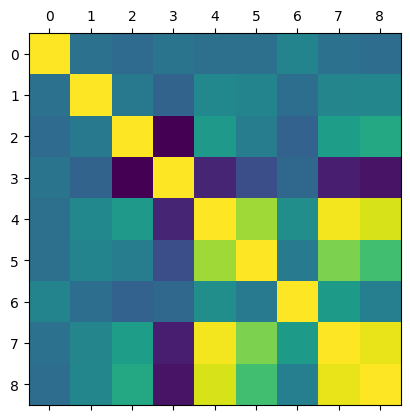

In [16]:
# Is there a correlation between features
# NOTE: this can only be done with numerical features
 
plt.matshow(bank_data_full.select_dtypes(exclude='object').corr())

<Axes: >

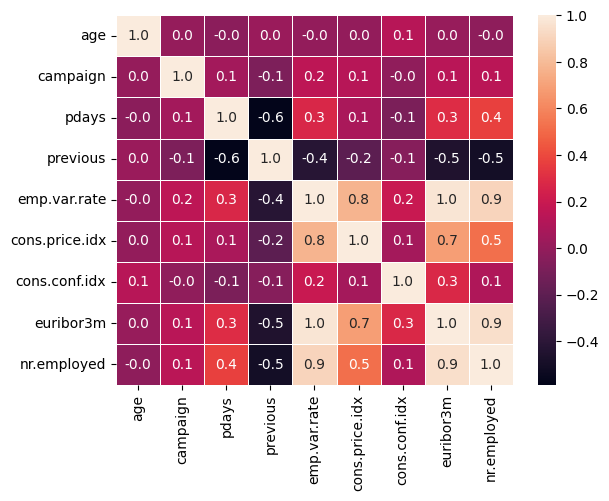

In [17]:
# What ss the correlation between features
# NOTE: this can only be done with numerical features
# NOTE 2: This means that this is not a way to determine a correlation with the target, because the target is yes/no

sns.heatmap(bank_data_full.select_dtypes(exclude='object').corr(), annot=True, linewidth=.5, fmt=".1f")

3 features hve a very high correlation (> 0.9): eurbor3m, emp.var.rate and nr.employed
Options are: 
- leave 2 out 
- combine the 3 to 1
- do nothing

### Make a binary from pdays

In [18]:

#Step 1: copy bank_data_fullto bank_data_full_p
bank_data_full_p = bank_data_full.copy()

#Step 2: add column based on Pdays
# Binary indicator
bank_data_full_p['contacted_before'] = (bank_data_full_p['pdays'] != 999).astype(int)

#step 3: remove column Pdays
bank_data_full_p = bank_data_full_p.drop(columns=['pdays'])

In [19]:
# split the dataframe i X and y
# in doing so, make yes=1 and no=0 (both as integer)
X = bank_data_full.drop("y", axis='columns')
y = bank_data_full["y"].replace(to_replace={'yes': '1', 'no': '0'}).astype(int)

In [20]:
X = bank_data_full_p

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               41188 non-null  int64  
 1   job               41188 non-null  object 
 2   marital           41188 non-null  object 
 3   education         41188 non-null  object 
 4   default           41188 non-null  object 
 5   housing           41188 non-null  object 
 6   loan              41188 non-null  object 
 7   contact           41188 non-null  object 
 8   month             41188 non-null  object 
 9   day_of_week       41188 non-null  object 
 10  campaign          41188 non-null  int64  
 11  previous          41188 non-null  int64  
 12  poutcome          41188 non-null  object 
 13  emp.var.rate      41188 non-null  float64
 14  cons.price.idx    41188 non-null  float64
 15  cons.conf.idx     41188 non-null  float64
 16  euribor3m         41188 non-null  float6

In [21]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 41188 entries, 0 to 41187
Series name: y
Non-Null Count  Dtype
--------------  -----
41188 non-null  int64
dtypes: int64(1)
memory usage: 321.9 KB


## Split data into Train en Test

In [22]:
# Split te dataframe training and testset, using stratify, because yes/no is imbalanced

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) #checking the shape of the splits
print("Train: ", len(X_train), "&",len(y_train))
print("Test: ", len(X_test), "&",len(y_test))

(32950, 20) (8238, 20) (32950,) (8238,)
Train:  32950 & 32950
Test:  8238 & 8238


# Create the generic pipeline

## Preprocessing

In [23]:
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
num_pipeline = make_pipeline(StandardScaler())

cat_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "contacted_before"]
num_features = ["age", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", num_pipeline, num_features)
    ])

# Train and test several models

## Model Logistic Regression

### Logistic Regression pipeline

In [24]:
#LogisticRegression pipeline
log_reg = make_pipeline(preprocessing, LogisticRegression(random_state=42))

### Train basic LR model

In [25]:
# Training without crossvalidation
log_reg.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluate basic LR model

#### Evaluate using Test set

In [26]:
# make a prediction on the test-set
y_test_pred_lr = log_reg.predict(X_test)

#predict probability, using the best estimator
y_test_proba_lr = log_reg.predict_proba(X_test)

In [27]:
# evaluate indicators
recall_log_reg = recall_score(y_test, y_test_pred_lr)
precision_log_reg = precision_score(y_test, y_test_pred_lr)
f1_log_reg = f1_score(y_test, y_test_proba_lr[:,1].round()) 
AUC_log_reg = roc_auc_score(y_test, y_test_proba_lr[:,1])   

print(f"Recall: {recall_log_reg:.3f}")
print(f'Precision: {precision_log_reg:.3f}')
print(f'F1 Score: {f1_log_reg:.3f}')
print(f'AUC: {AUC_log_reg:.3f}')

Recall: 0.219
Precision: 0.684
F1 Score: 0.331
AUC: 0.800


              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.68      0.22      0.33       928

    accuracy                           0.90      8238
   macro avg       0.80      0.60      0.64      8238
weighted avg       0.88      0.90      0.88      8238



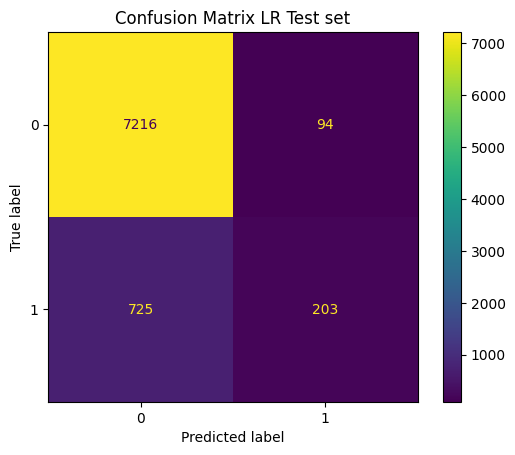

In [28]:
#Classification report on Test set
classification_report_lr = classification_report(y_test, y_test_pred_lr)
print(classification_report_lr)

#Confusion Matrix Test set
conf_matrix = confusion_matrix(y_test, y_test_pred_lr)  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=log_reg.classes_)
disp.plot()
plt.title("Confusion Matrix LR Test set")
plt.show()

#### Evaluate drawing curves on train set

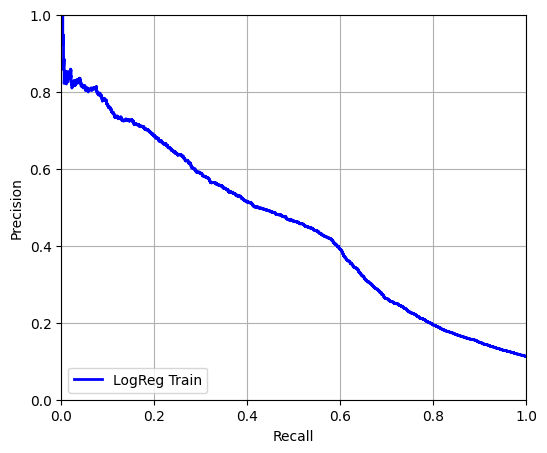

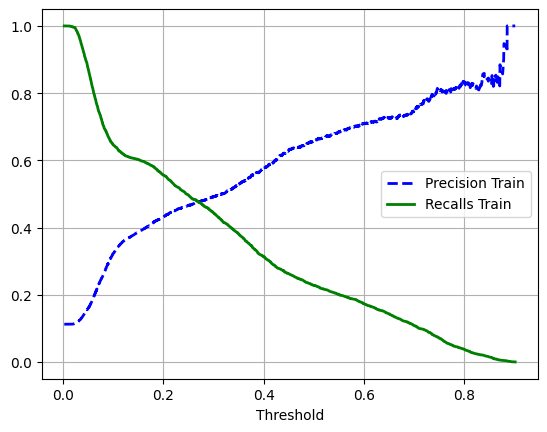

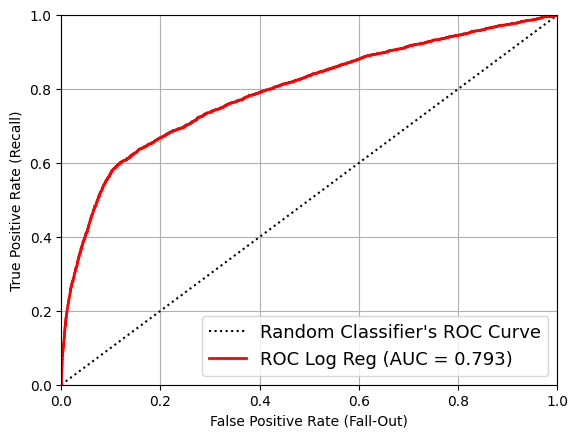

In [29]:
#Draw curves on TRAIN set
y_train_proba_lr = log_reg.predict_proba(X_train)

train_precisions_lr, train_recalls_lr, train_thresholds_lr = precision_recall_curve(y_train, y_train_proba_lr[:,1])

plt.figure(figsize=(6, 5))

# recall vs precision
plt.plot(train_recalls_lr, train_precisions_lr, "b-", linewidth=2, label="LogReg Train")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

# recall and precision vs thresholds
plt.plot(train_thresholds_lr, train_precisions_lr[:-1], "b--", label="Precision Train", linewidth=2)
plt.plot(train_thresholds_lr, train_recalls_lr[:-1], "g-", label="Recalls Train", linewidth=2)
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

# ROC AUC
# TPR's & FPR's
fpr_train_lr, tpr_train_lr, _ = roc_curve(y_train, y_train_proba_lr[:,1])

#compute the AUC scores
auc_train_lr = roc_auc_score(y_train, y_train_proba_lr[:,1])

#plot the Random Classifier
plt.plot([0,1], [0,1], 'k:', label = "Random Classifier's ROC Curve")

#plot the ROC's of the models & the AUC's
plt.plot(fpr_train_lr, tpr_train_lr, "r-", linewidth=2, label=f"ROC Log Reg (AUC = {auc_train_lr:.3f})")

#some formatting
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

#### Evaluate using Hyperparamater tuning & Cross Validating LR Model with GridSearch

The hyperparameters for Logistic regression are:
- Penalty
- Solver
- max_iter
- l1_ratio (Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.)

In [30]:
# Check the parameters of the baseline Logistic Regression model
log_reg.named_steps['logisticregression'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [31]:
param_grid = [    
    {'logisticregression__solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'logisticregression__penalty' : ['l2', None],
     'logisticregression__max_iter' : [100, 500, 1000]
    },
    {'logisticregression__solver' : ['liblinear'],
     'logisticregression__penalty' : ['l1', 'l2'],
     'logisticregression__max_iter' : [100, 500, 1000]
    },
    {'logisticregression__solver' : ['saga'],
     'logisticregression__penalty' : ['l1', 'l2', None],
     'logisticregression__max_iter' : [100, 500, 1000]
    },
    {'logisticregression__solver' : ['saga'],
     'logisticregression__penalty' : ['elasticnet'],
     'logisticregression__max_iter' : [100, 500, 1000],
     'logisticregression__l1_ratio' : [0.1, 0.5, 0.9]
    }
    ]

#Using 10 folds in crossvalidating
log_reg_grid_search = GridSearchCV(log_reg, param_grid = param_grid, cv = 10, verbose=True, n_jobs=-1, error_score='raise')

log_reg_grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 48 candidates, totalling 480 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'logisticregression__max_iter': [100, 500, ...], 'logisticregression__penalty': ['l2', None], 'logisticregression__solver': ['lbfgs', 'newton-cg', ...]}, {'logisticregression__max_iter': [100, 500, ...], 'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__solver': ['liblinear']}, ...]"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [32]:
log_reg_grid_search.best_params_

{'logisticregression__l1_ratio': 0.5,
 'logisticregression__max_iter': 500,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__solver': 'saga'}

In [33]:
log_reg_grid_search.best_estimator_

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
#predict, using the best estimator
y_train_proba_lr_be = log_reg_grid_search.best_estimator_.predict_proba(X_train)

In [35]:
# evaluate best estimator
recall_log_reg_be = recall_score(y_train, y_train_proba_lr_be[:,1].round())
precision_log_reg_be = precision_score(y_train, y_train_proba_lr_be[:,1].round())
f1_log_reg_be = f1_score(y_train, y_train_proba_lr_be[:,1].round()) 
AUC_log_reg_be = roc_auc_score(y_train, y_train_proba_lr_be[:,1])   

print(f"Recall: {recall_log_reg_be:.3f}")
print(f'Precision: {precision_log_reg_be:.3f}')
print(f'F1 Score: {f1_log_reg_be:.3f}')
print(f'AUC: {AUC_log_reg_be:.3f}')

Recall: 0.230
Precision: 0.658
F1 Score: 0.340
AUC: 0.793


#### Draw curves of best LR model

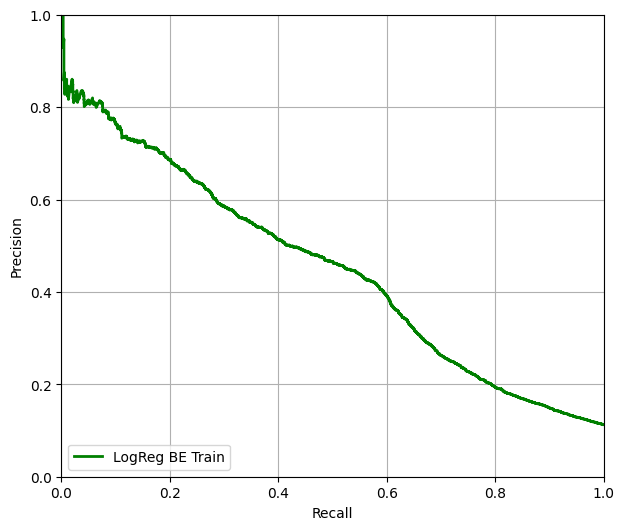

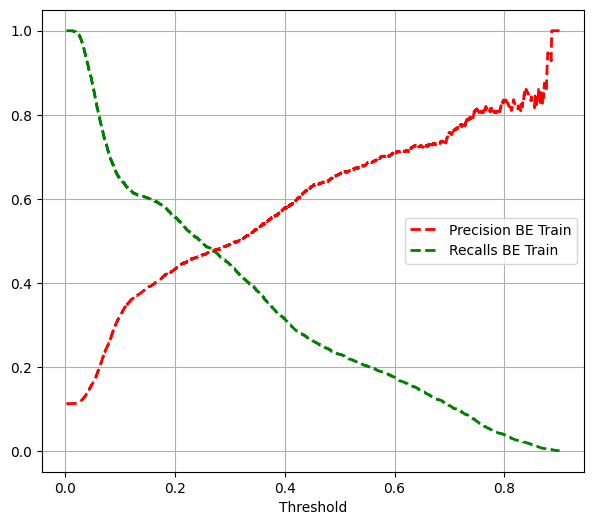

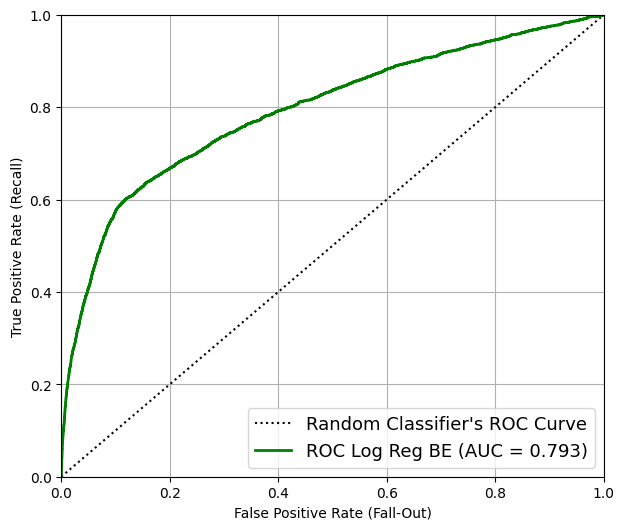

In [36]:
# Draw the Curve(s)
train_precisions_lr_be, train_recalls_lr_be, train_thresholds_lr_be = precision_recall_curve(y_train, y_train_proba_lr_be[:, 1])

# recall vs precision
plt.figure(figsize=(7, 6))
plt.plot(train_recalls_lr_be, train_precisions_lr_be, "g-", linewidth=2, label="LogReg BE Train")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

# recall and precision vs thresholds
plt.figure(figsize=(7, 6))
plt.plot(train_thresholds_lr_be, train_precisions_lr_be[:-1], "r--", label="Precision BE Train", linewidth=2)
plt.plot(train_thresholds_lr_be, train_recalls_lr_be[:-1], "g--", label="Recalls BE Train", linewidth=2)
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

# TPR's & FPR's
fpr_lr_be, tpr_lr_be, _ = roc_curve(y_train, y_train_proba_lr_be[:,1])


#compute the AUC scores
auc_lr_be = roc_auc_score(y_train, y_train_proba_lr_be[:,1])

# Start plotting
plt.figure(figsize=(7, 6))

#plot the Random Classifier
plt.plot([0,1], [0,1], 'k:', label = "Random Classifier's ROC Curve")

#plot the ROC's of the models & the AUC's
plt.plot(fpr_lr_be, tpr_lr_be, "g-", linewidth=2, label=f"ROC Log Reg BE (AUC = {auc_lr_be:.3f})")

#some formatting
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

#### Confusion Matrix Best Estimator on Test set

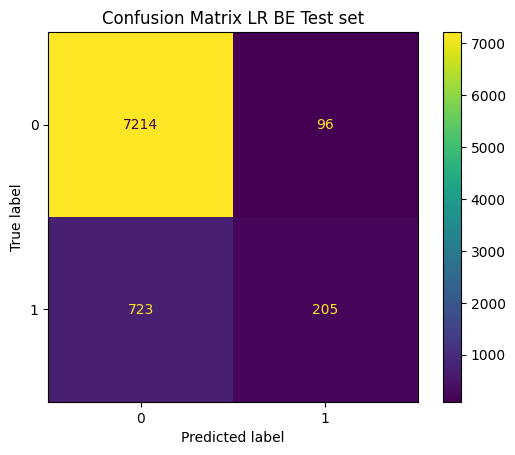

In [37]:
#predict, using the best estimator
y_test_pred_lr_be = log_reg_grid_search.best_estimator_.predict(X_test)

#Confusion Matrix Test set with best estimator
conf_matrix_be_lr = confusion_matrix(y_test, y_test_pred_lr_be)  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_be_lr,
                              display_labels=log_reg_grid_search.best_estimator_.classes_)
disp.plot()
plt.title("Confusion Matrix LR BE Test set")
plt.show()

#### Conclusion of evaluation
- Recall and Precision on Train set and Test set are similar
- ROC AUC looks OK
- Best model scores similar to basic model
- LR model is usable

### Costbased Thresholding LR

#### Cost of FP and FN

In [38]:
call_cost_fixed = 15
call_cost_minute = 3
revenue_missed = 100

# False Positive is een onnodig gevoerd gesprek
cost_unsuccesfull_call = call_cost_fixed + (average_call_minutes * call_cost_minute)

# False Negative is een niet gevoerd, maar wel gewenst gesprek
cost_missed_call = revenue_missed
print (f"Kosten onnodig gesprek (FP): {cost_unsuccesfull_call}")
print (f"Kosten gemist gesprek (FN): {cost_missed_call}")

Kosten onnodig gesprek (FP): 27.9
Kosten gemist gesprek (FN): 100


#### Calculation of Costs & Optimal threshold

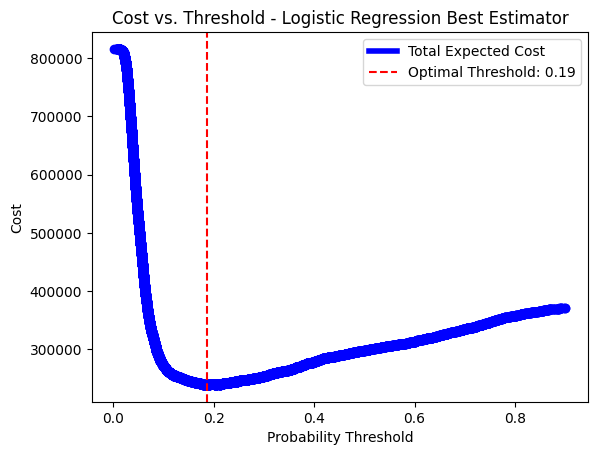

Optimal threshold for Logistic Regression Best Estimator: 0.19
Precision: 0.42
Recall: 0.58
Empirically minimized expected costs: 239151.70
Empirically minimized expected costs per item: 7.26
 
With calibrated p threshold would be: 0.22
Expected cost with this calibrated p threshold: 241580.70


In [39]:
th_lr = empirical_costbased_thresholding(y_train, y_train_proba_lr_be[:,1], "Logistic Regression Best Estimator", cost_unsuccesfull_call, cost_missed_call, p=True)

#### Average Cost

In [ ]:
y_pred_logreg = (log_reg_grid_search.best_estimator_.predict_proba(X_test)[:,1]) > th_lr
av_testscore_logreg = myAveragedCosts(y_test, y_pred_logreg, cost_unsuccesfull_call, cost_missed_call)
print(f'Logreg Av Costs: {av_testscore_logreg:.5f}')

logreg Av Costs: 6.80422


## Model Random Forest

In [40]:
#random forest pipeline
rf_clf = make_pipeline(preprocessing, RandomForestClassifier(random_state=42))  
# Training the Random Forest Classifier
rf_clf.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
#cross validated predict probabilities on TRAINING set
y_train_proba_rf_cv = cross_val_predict(rf_clf, X_train, y_train, cv=5, method="predict_proba")  

# Evaluate on TRAIN set (cross validated)
precision_rf_cv = precision_score(y_train, y_train_proba_rf_cv[:,1].round())
recall_rf_cv = recall_score(y_train, y_train_proba_rf_cv[:,1].round())
f1_rf_cv = f1_score(y_train, y_train_proba_rf_cv[:,1].round())
AUC_rf_cv = roc_auc_score(y_train, y_train_proba_rf_cv[:,1])

print("Random Forest Evaluation on TRAIN set (cross validated):")
print(f'Precision: {precision_rf_cv:.3f}')
print(f"Recall: {recall_rf_cv:.3f}")    
print(f'F1 Score: {f1_rf_cv:.3f}')
print(f'AUC: {AUC_rf_cv:.3f}')



Random Forest Evaluation on TRAIN set (cross validated):
Precision: 0.527
Recall: 0.276
F1 Score: 0.363
AUC: 0.769


In [42]:
# Predict on TEST set
y_test_pred_rf = rf_clf.predict(X_test)

# Evaluate on TEST set
precision_rf=precision_score(y_test, y_test_pred_rf)
recall_rf=recall_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf)
auc_rf = roc_auc_score(y_test, y_test_pred_rf)

print("Random Forest Evaluation on test set:")

print(f"Precision: {precision_rf:.3f}")
print(f"Recall: {recall_rf:.3f}")
print(f"F1 Score: {f1_rf:.3f}")
print(f"AUC: {auc_rf:.3f}")


Random Forest Evaluation on test set:
Precision: 0.580
Recall: 0.290
F1 Score: 0.386
AUC: 0.632


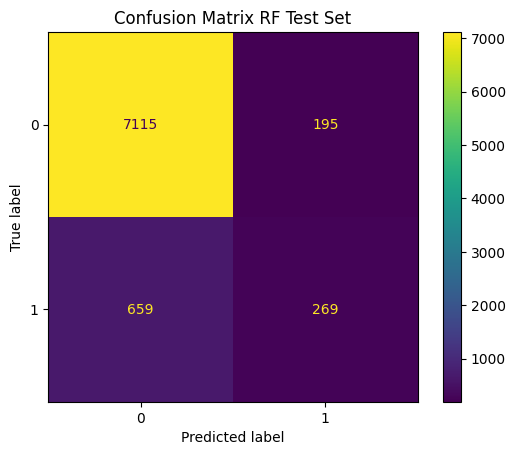

In [43]:
#Confusion Matrix Test set
conf_matrix = confusion_matrix(y_test, y_test_pred_rf)  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=rf_clf.classes_)
disp.plot()
plt.title("Confusion Matrix RF Test Set")
plt.show()

### Hyperparameter tuning RF Model, using GridSearch

- model__n_estimators (Number of trees in the forest: Trying 100 or 300 trees)
- model__max_depth (Maximum depth of each tree)
- model__min_samples_split (Minimum number of samples required to split a node)

In [44]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": [350, 400],
    "randomforestclassifier__max_depth": [None, 10, 20],
    "randomforestclassifier__min_samples_split": [10, 15, 20]
}

rf_grid_search = GridSearchCV(rf_clf, param_grid = param_grid_rf, cv = 10, verbose=True, n_jobs=-1, error_score='raise')

rf_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'randomforestclassifier__max_depth': [None, 10, ...], 'randomforestclassifier__min_samples_split': [10, 15, ...], 'randomforestclassifier__n_estimators': [350, 400]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [45]:
rf_grid_search.best_estimator_

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
#predict, using the best estimator
y_train_proba_rf_be = rf_grid_search.best_estimator_.predict_proba(X_train)


In [47]:
# Evaluate on TRAIN set (best estimator)
precision_rf_be = precision_score(y_train, y_train_proba_rf_be[:,1].round())
recall_rf_be = recall_score(y_train, y_train_proba_rf_be[:,1].round())
f1_rf_be = f1_score(y_train, y_train_proba_rf_be[:,1].round())
AUC_rf_be = roc_auc_score(y_train, y_train_proba_rf_be[:,1])

print("Random Forest Evaluation on TRAIN set (best estimator):")
print(f'Precision: {precision_rf_be:.3f}')
print(f"Recall: {recall_rf_be:.3f}")
print(f'F1 Score: {f1_rf_be:.3f}')
print(f'AUC: {AUC_rf_be:.3f}')



Random Forest Evaluation on TRAIN set (best estimator):
Precision: 0.795
Recall: 0.268
F1 Score: 0.401
AUC: 0.842


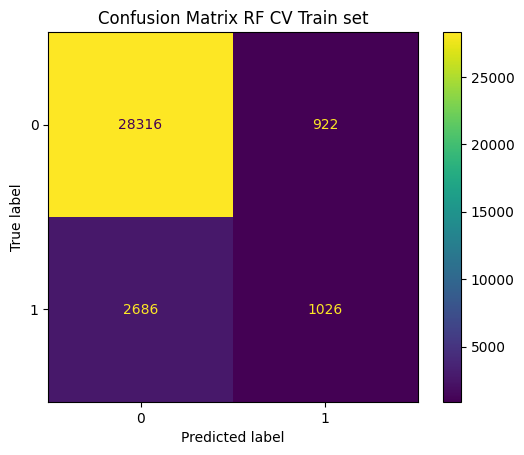

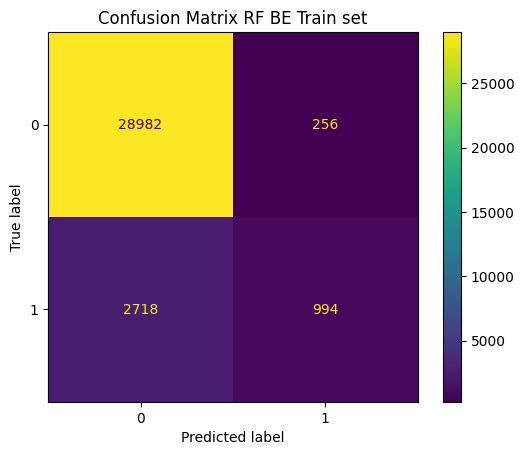

In [48]:
#Confusion Matrix cross validated
conf_matrix_cv = confusion_matrix(y_train, y_train_proba_rf_cv[:,1].round())   
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_cv,
                              display_labels=rf_clf.classes_)
disp.plot()
plt.title("Confusion Matrix RF CV Train set")
plt.show()

#Confusion Matrix best estimator
conf_matrix_be = confusion_matrix(y_train, y_train_proba_rf_be[:,1].round())  
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_be,
                              display_labels=rf_grid_search.best_estimator_.classes_)
disp.plot()
plt.title("Confusion Matrix RF BE Train set")
plt.show()

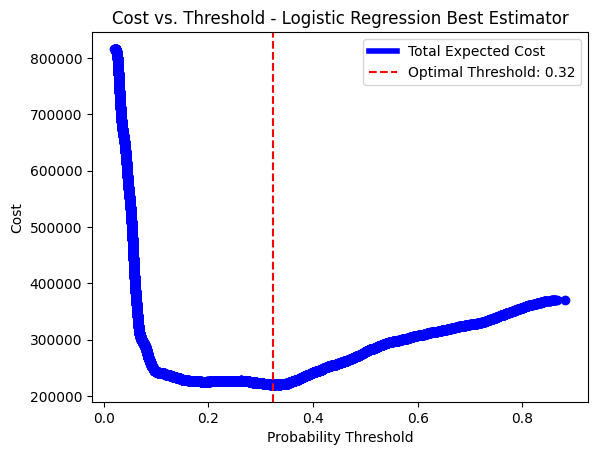

Optimal threshold for Logistic Regression Best Estimator: 0.32
Precision: 0.57
Recall: 0.52
Empirically minimized expected costs: 219961.90
Empirically minimized expected costs per item: 6.68
 
With calibrated p threshold would be: 0.22
Expected cost with this calibrated p threshold: 226985.10


In [59]:
th_rf = empirical_costbased_thresholding(y_train, y_train_proba_rf_be[:,1], "Logistic Regression Best Estimator", cost_unsuccesfull_call, cost_missed_call, p=True)

## Model KNN (5)

In [49]:
#KNeighbors pipeline
knn_clf = make_pipeline(preprocessing, KNeighborsClassifier())  
#Training the KNeighbors Classifier
knn_clf.fit(X_train, y_train)   

,steps,"[('columntransformer', ...), ('kneighborsclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [50]:
#cross validated predict probalities on TRAINING set
y_train_proba_knn_cv = cross_val_predict(knn_clf, X_train, y_train, cv=5, method="predict_proba") 

# Evaluate on TRAIN set (cross validated)

precision_knn_cv = precision_score(y_train, y_train_proba_knn_cv[:,1].round())
recall_knn_cv = recall_score(y_train, y_train_proba_knn_cv[:,1].round())
f1_knn_cv = f1_score(y_train, y_train_proba_knn_cv[:,1].round())
AUC_knn_cv = roc_auc_score(y_train, y_train_proba_knn_cv[:,1])

print("KNeighbors Evaluation on TRAIN set (cross validated):")
      
print(f'Precision: {precision_knn_cv:.3f}')
print(f"Recall: {recall_knn_cv:.3f}")    
print(f'F1 Score: {f1_knn_cv:.3f}')
print(f'AUC: {AUC_knn_cv:.3f}')



KNeighbors Evaluation on TRAIN set (cross validated):
Precision: 0.507
Recall: 0.267
F1 Score: 0.350
AUC: 0.720


In [51]:
# Predict on TEST set
y_test_pred_knn = knn_clf.predict(X_test)

# Evaluate on TEST set
precision_knn=precision_score(y_test, y_test_pred_knn)
recall_knn=recall_score(y_test, y_test_pred_knn)
f1_knn = f1_score(y_test, y_test_pred_knn)
auc_knn = roc_auc_score(y_test, y_test_pred_knn)

print("KNeighbors Evaluation on test set:")

print(f"Precision: {precision_knn:.3f}")
print(f"Recall: {recall_knn:.3f}")
print(f"F1 Score: {f1_knn:.3f}")
print(f"AUC: {auc_knn:.3f}")



KNeighbors Evaluation on test set:
Precision: 0.569
Recall: 0.296
F1 Score: 0.390
AUC: 0.634


Confusion Matrix KNeighbors Test set:


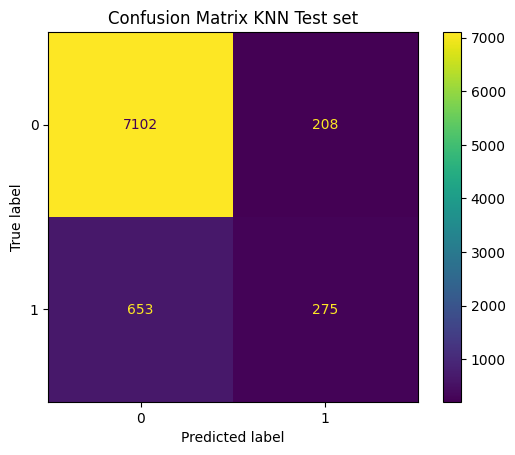

In [52]:
#Confusion Matrix Test set
conf_matrix_knn = confusion_matrix(y_test, y_test_pred_knn)  
print("Confusion Matrix KNeighbors Test set:")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn,
                              display_labels=knn_clf.classes_)
disp.plot()
plt.title("Confusion Matrix KNN Test set")
plt.show()


### Hyperparamater tuning KNN Model, using GridSearch
- model__n_neighbors (The number of nearest neighbors KNN uses to make a prediction)
- model__weights (How each neighbor contributes to the prediction. Options: "uniform" → every neighbor has equal weight. "distance" → closer neighbors count more than farther ones).

In [53]:
param_grid_knn = {
    "kneighborsclassifier__n_neighbors": [5, 20, 100],
    "kneighborsclassifier__weights": ["uniform", "distance"]
}

knn_grid_search = GridSearchCV(knn_clf, param_grid = param_grid_knn, cv = 10, verbose=True, n_jobs=-1, error_score='raise')

knn_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'kneighborsclassifier__n_neighbors': [5, 20, ...], 'kneighborsclassifier__weights': ['uniform', 'distance']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [54]:
#predict, using the best estimator
y_train_proba_knn_be = knn_grid_search.best_estimator_.predict_proba(X_train)


In [55]:
# Evaluate on TRAIN set (best estimator)
precision_knn_be = precision_score(y_train, y_train_proba_knn_be[:,1].round())
recall_knn_be = recall_score(y_train, y_train_proba_knn_be[:,1].round())
f1_knn_be = f1_score(y_train, y_train_proba_knn_be[:,1].round())
AUC_knn_be = roc_auc_score(y_train, y_train_proba_knn_be[:,1])

print("KNeighbors Classifier Evaluation on TRAIN set (best estimator):")
print(f'Precision: {precision_knn_be:.3f}')
print(f"Recall: {recall_knn_be:.3f}")
print(f'F1 Score: {f1_knn_be:.3f}')
print(f'AUC: {AUC_knn_be:.3f}')

KNeighbors Classifier Evaluation on TRAIN set (best estimator):
Precision: 0.694
Recall: 0.238
F1 Score: 0.355
AUC: 0.858


# Comparison of Models

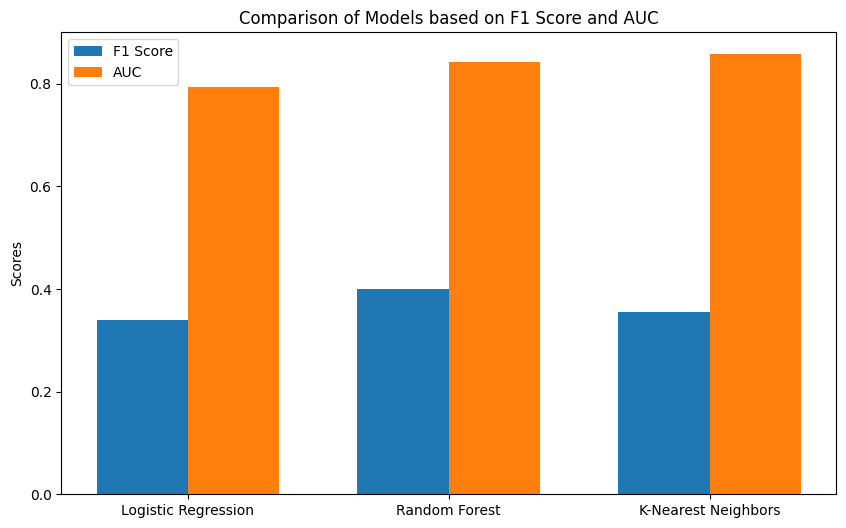

In [56]:
# Comparison of models based on F1 Score and AUC
models = ['Logistic Regression', 'Random Forest', 'K-Nearest Neighbors']    
f1_scores = [f1_log_reg_be, f1_rf_be, f1_knn_be]
auc_scores = [auc_lr_be, AUC_rf_be, AUC_knn_be]
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score')
rects2 = ax.bar(x + width/2, auc_scores, width, label='AUC')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Models based on F1 Score and AUC')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()



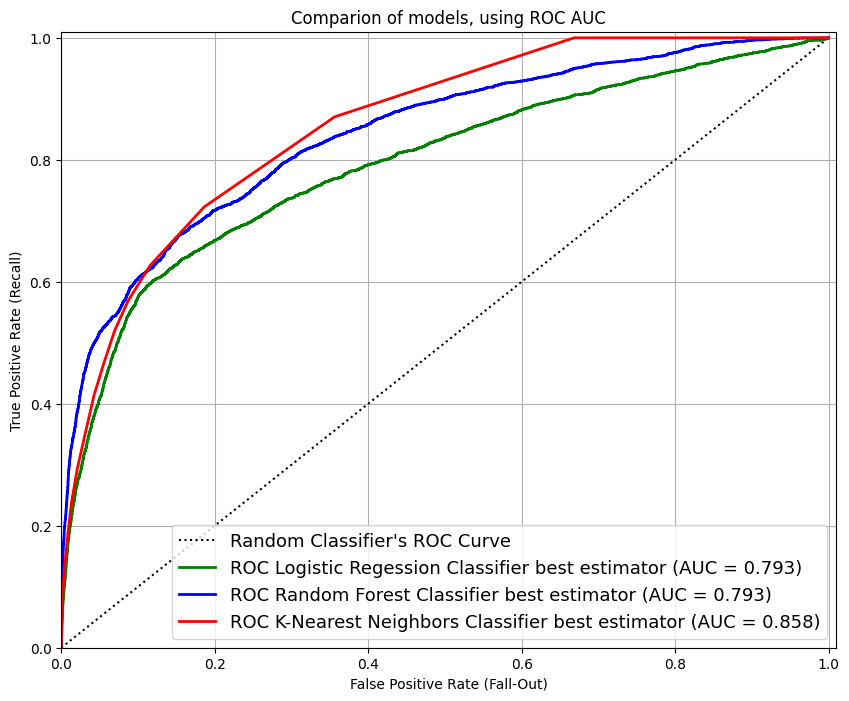

In [57]:
# TPR's & FPR's
fpr_lr_be, tpr_lr_be, _ = roc_curve(y_train, y_train_proba_lr_be[:,1])
fpr_rf_be, tpr_rf_be, _ = roc_curve(y_train, y_train_proba_rf_be[:,1])
fpr_knn_be, tpr_knn_be, _ = roc_curve(y_train, y_train_proba_knn_be[:,1])   

#compute the AUC scores
auc_lr_be = roc_auc_score(y_train, y_train_proba_lr_be[:,1])
auc_rf_be = roc_auc_score(y_train, y_train_proba_rf_be[:,1])
auc_knn_be = roc_auc_score(y_train, y_train_proba_knn_be[:,1])

# Start plotting
plt.figure(figsize=(10,8))

#plot the Random Classifier
plt.plot([0,1], [0,1], 'k:', label = "Random Classifier's ROC Curve")

#plot the ROC's of the models & the AUC's
plt.plot(fpr_lr_be, tpr_lr_be, "g-", linewidth=2, label=f"ROC Logistic Regession Classifier best estimator (AUC = {auc_lr_be:.3f})")
plt.plot(fpr_rf_be, tpr_rf_be, "b-", linewidth=2, label=f"ROC Random Forest Classifier best estimator (AUC = {auc_lr_be:.3f})")
plt.plot(fpr_knn_be, tpr_knn_be, "r-", linewidth=2, label=f"ROC K-Nearest Neighbors Classifier best estimator (AUC = {auc_knn_be:.3f})")
         

#some formatting
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title("Comparion of models, using ROC AUC")
plt.grid()
plt.axis([0, 1.01, 0, 1.01])
plt.legend(loc="lower right", fontsize=13)
plt.show()